In [14]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import math
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import os

In [31]:
# PART 1: The Custom Continuous Cart-Pole Environment
# ---------------------------------------------------------
class ContinuousCartPoleEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, compute_terminated=True):
        super(ContinuousCartPoleEnv, self).__init__()

        # --- Physics Constants ---
        self.gravity = 9.8
        self.mass_cart = 1.0
        self.mass_pole = 0.1
        self.total_mass = self.mass_cart + self.mass_pole
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.mass_pole * self.length
        self.force_mag = 10.0  # Max force (Newtons)
        self.tau = 0.02  # Seconds between state updates (dt)

        # Limits for the simulation to end
        self.theta_threshold_radians = 12 * 2 * math.pi / 360  # +/- 12 degrees
        self.x_threshold = 2.4
        self.compute_terminated = compute_terminated

        # --- Action Space ---
        # Continuous force between -10N and +10N
        self.action_space = spaces.Box(
            low=-self.force_mag, 
            high=self.force_mag, 
            shape=(1,), 
            dtype=np.float32
        )

        # --- Observation Space ---
        # [x, x_dot, theta, theta_dot]
        # We set high limits for observation, though physics will likely exceed them slightly
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max
        ], dtype=np.float32)

        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.state = None

    def step(self, action):
        # 1. Unpack State
        x, x_dot, theta, theta_dot = self.state
        
        # 2. Clip Action (Force)
        force = np.clip(action, -self.force_mag, self.force_mag)[0]
        
        # 3. The Math (Dynamics Equations)
        # Cos/Sin for ease of reading
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # Intermediate calculation for the coupled system
        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        
        # Angular Acceleration (Theta Double Dot)
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
                   (self.length * (4.0/3.0 - self.mass_pole * costheta**2 / self.total_mass))
        
        # Linear Acceleration (X Double Dot)
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        # 4. Euler Integration (Update State)
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = (x, x_dot, theta, theta_dot)

        # 5. Check Termination (Game Over conditions)
        terminated = False
        if self.compute_terminated:
            terminated = bool(
                x < -self.x_threshold
                or x > self.x_threshold
                or theta < -self.theta_threshold_radians
                or theta > self.theta_threshold_radians
            )
        else:
            terminated = False

        # 6. Reward Function
        # Standard CartPole gives +1 for every step you survive.
        # For Continuous Control, we often add a penalty for using too much force (Energy efficiency)
        if not terminated:
            # 1. Base reward for surviving
            reward = 1.0 
            
            # 2. Penalty for Angle (We want theta close to 0)
            # We multiply by 10 to make this penalty significant
            reward -= 10.0 * (theta ** 2)
            
            # 3. Penalty for Position (We want cart at center x=0)
            # This prevents the cart from running away to infinity
            reward -= 0.1 * (x ** 2)
            
            # 4. Penalty for Angular Velocity (We want pole to be still, not vibrating)
            reward -= 0.1 * (theta_dot ** 2)
            
        else:
            # Heavy penalty for crashing
            reward = -10.0

        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Start with a slightly random state [-0.5, 0.5]
        self.state = self.np_random.uniform(low=-0.5, high=0.5, size=(4,))
        return np.array(self.state, dtype=np.float32), {}

In [16]:
# PART 2: Training the Agent
# ---------------------------------------------------------

# Create logging directory
log_dir = "logs_cont_cartpole"
os.makedirs(log_dir, exist_ok=True)

# 1. Initialize Environment
env = ContinuousCartPoleEnv()
env = Monitor(env, log_dir)

# 2. Initialize PPO
# We use a slightly smaller learning rate for continuous control stability
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0002,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    ent_coef=0.01          # Encourage exploration so it doesn't get stuck doing nothing
)

print("--------------- STARTING TRAINING ---------------")
# 100,000 steps is usually enough for this problem
model.learn(total_timesteps=100000)
print("--------------- TRAINING COMPLETE ---------------")

Using cuda device
Wrapping the env in a DummyVecEnv.
--------------- STARTING TRAINING ---------------


c:\Users\leste\miniconda3\envs\RL_tutorial\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.2     |
|    ep_rew_mean     | -1.41    |
| time/              |          |
|    fps             | 1049     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 8.95         |
|    ep_rew_mean          | -3.38        |
| time/                   |              |
|    fps                  | 740          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0018674257 |
|    clip_fraction        | 0.00405      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.00241     |
|    learning_r

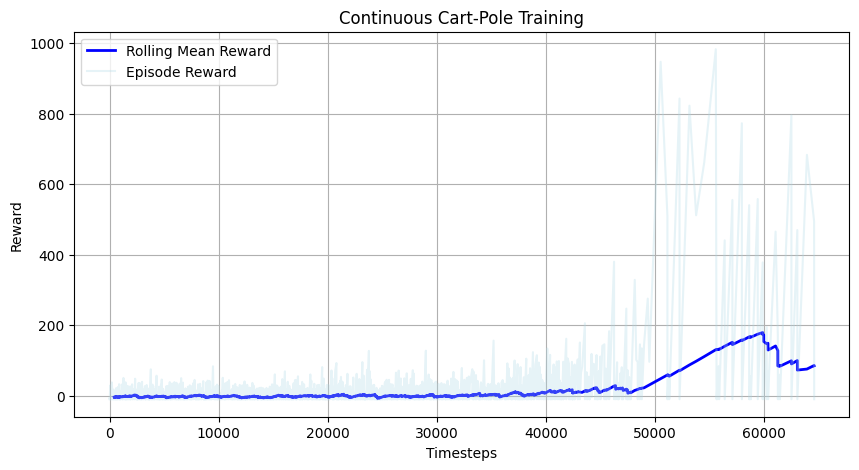


--- TEST RUN ---
Step 0: Pos=0.18m | Angle=-17.82° | Force=-5.01N
CartPole fell!
Total Test Reward: -10.0


In [17]:
# PART 3: Visualization & Validation
# ---------------------------------------------------------

# Plot Learning Curve
def plot_results(log_folder):
    df = results_plotter.load_results(log_folder)
    if len(df) > 0:
        plt.figure(figsize=(10, 5))
        # Create rolling mean
        window = 50
        if len(df) >= window:
            y = df.r.values
            x = df.l.cumsum().values
            rolling_mean = np.convolve(y, np.ones(window)/window, mode='valid')
            plt.plot(x[window-1:], rolling_mean, color='blue', linewidth=2, label='Rolling Mean Reward')
            plt.plot(x, y, color='lightblue', alpha=0.3, label='Episode Reward')
            
        plt.xlabel("Timesteps")
        plt.ylabel("Reward")
        plt.title("Continuous Cart-Pole Training")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_results(log_dir)

# Numerical Test
print("\n--- TEST RUN ---")
obs, _ = env.reset()
total_reward = 0
for i in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    
    # Print status every 20 steps
    if i % 20 == 0:
        cart_pos = obs[0]
        pole_angle_deg = math.degrees(obs[2])
        force_applied = action[0]
        print(f"Step {i}: Pos={cart_pos:.2f}m | Angle={pole_angle_deg:.2f}° | Force={force_applied:.2f}N")

    if done:
        print("CartPole fell!")
        break

print(f"Total Test Reward: {total_reward}")


--- STARTING CONVERGENCE TEST ---
[0.  0.  0.4 0. ]


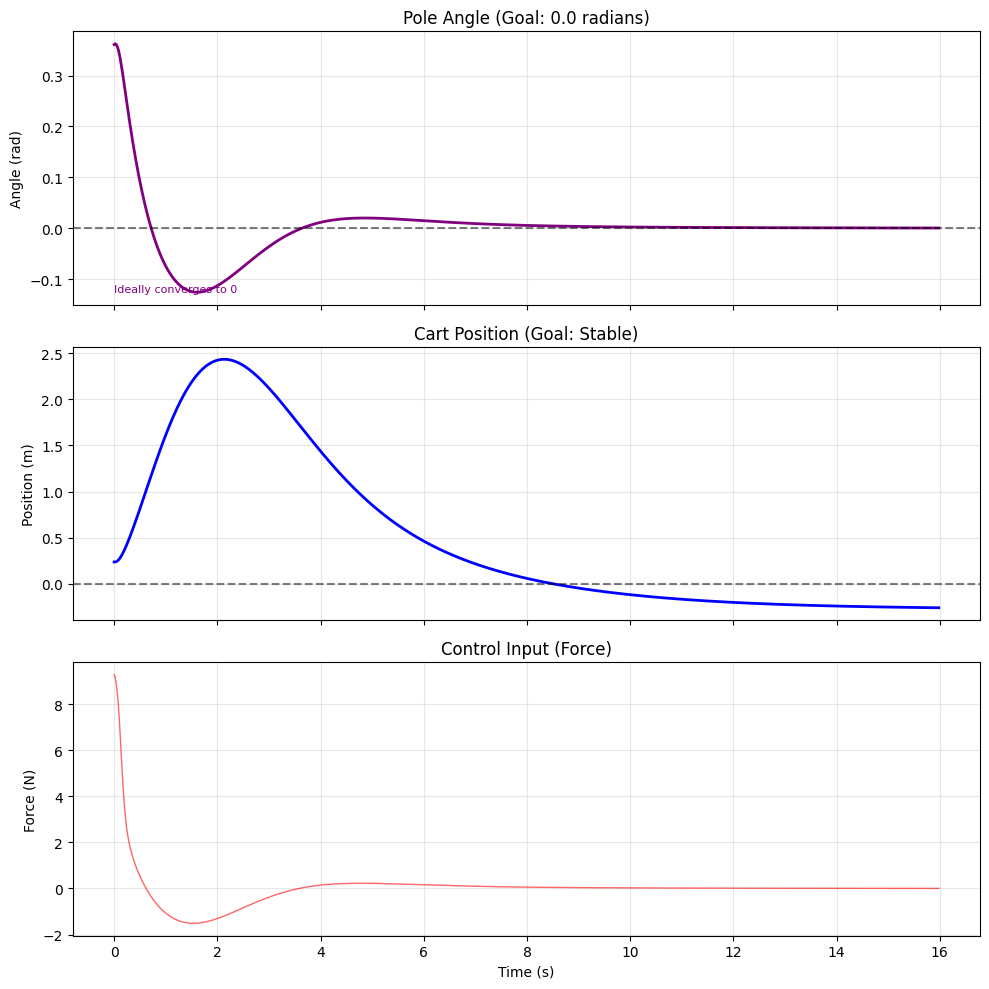

In [ ]:
# PART 4: Convergence Visualization
# ---------------------------------------------------------

import matplotlib.pyplot as plt

print("\n--- STARTING CONVERGENCE TEST ---")
env = ContinuousCartPoleEnv(compute_terminated=False)
obs, _ = env.reset()
delta_t = env.unwrapped.tau

# Data storage
history_steps = []
history_angle = []
history_pos = []
history_force = []

# Run simulation for 800 steps (enough time to see stabilization)
for i in range(800):
    # Predict best action (deterministic=True disables random exploration noise)
    action, _ = model.predict(obs, deterministic=True)
    
    # Step the environment
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Store observations
    # obs structure: [x, x_dot, theta, theta_dot]
    history_steps.append(i)
    history_pos.append(obs[0])      # Cart Position
    history_angle.append(obs[2])    # Pole Angle
    history_force.append(action[0]) # Force Applied
    
    if terminated:
        print(f"Episode failed (Terminated) at step {i}")
        break

# Create the Plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Convert step indices to time (seconds) to avoid multiplying a Python list by a float
times = np.array(history_steps) * delta_t

# 1. Angle Plot (The most important for balance)
ax1.plot(times, history_angle, color='purple', linewidth=2)
ax1.axhline(0, color='black', linestyle='--', alpha=0.5) # Target line
ax1.set_title("Pole Angle (Goal: 0.0 radians)")
ax1.set_ylabel("Angle (rad)")
ax1.grid(True, alpha=0.3)
ax1.text(0, min(history_angle), "Ideally converges to 0", fontsize=8, color='purple')

# 2. Position Plot
ax2.plot(times, history_pos, color='blue', linewidth=2)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5) # Center of track
ax2.set_title("Cart Position (Goal: Stable)")
ax2.set_ylabel("Position (m)")
ax2.grid(True, alpha=0.3)

# 3. Force Plot (Control Effort)
ax3.plot(times, history_force, color='red', alpha=0.6, linewidth=1)
ax3.set_title("Control Input (Force)")
ax3.set_ylabel("Force (N)")
ax3.set_xlabel("Time (s)")
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()